# Shakespearean English Translator Demo

This notebook demonstrates interactive English → Shakespearean English translation using fine-tuned T5 models on both a tiny, perfectly aligned dataset and a large, noisy dataset. It is designed for Colab or local Jupyter environments and runs on CPU, MPS (Apple Silicon), or CUDA.

## 1. Setup & Imports

Install required packages (uncomment if running in Colab):
```python
# !pip install torch transformers sentencepiece nltk rouge-score matplotlib
```

In [2]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
import matplotlib.pyplot as plt
import json

## 2. Load the Tiny Shakespeare T5 Model

In [3]:
MODEL_DIR = "tiny-shakespeare-t5"
tokenizer = T5Tokenizer.from_pretrained(MODEL_DIR)
model = T5ForConditionalGeneration.from_pretrained(MODEL_DIR)

device = (
    "mps" if torch.backends.mps.is_available() else
    "cuda" if torch.cuda.is_available() else
    "cpu"
)
model = model.to(device)
print(f"Using device: {device}")

Using device: mps


## 3. Define Translation Function

In [4]:
def translate(text, max_length=64):
    input_text = f"translate English to Shakespearean: {text}"
    inputs = tokenizer(input_text, return_tensors="pt").to(device)
    output = model.generate(**inputs, max_length=max_length)
    return tokenizer.decode(output[0], skip_special_tokens=True)

## 4. Try Interactive Translation

In [5]:
examples = [
    "How are you?",
    "Where is the king?",
    "I love you.",
    "This is a test.",
    "The weather is nice today."
]
for ex in examples:
    print(f"English: {ex}")
    print(f"Shakespearean: {translate(ex)}\n")

English: How are you?
Shakespearean: How dost thou?

English: Where is the king?
Shakespearean: How dost thou?

English: Where is the king?
Shakespearean: Wo ist der König?

English: I love you.
Shakespearean: I do love thee.

English: This is a test.
Shakespearean: Shakespearean ist ein Test.

English: The weather is nice today.
Shakespearean: Wo ist der König?

English: I love you.
Shakespearean: I do love thee.

English: This is a test.
Shakespearean: Shakespearean ist ein Test.

English: The weather is nice today.
Shakespearean: The weather is nice today.

Shakespearean: The weather is nice today.



## 5. Custom Input

In [6]:
text = input("Enter an English sentence: ")
print("Shakespearean:", translate(text))

Shakespearean: I do love thee.


## 6. BLEU Score Evaluation (Tiny Set)

In [8]:
from nltk.translate.bleu_score import sentence_bleu
# Add your tiny test set pairs here
references = [
    "How dost thou?".split(),
    "Where is the king?".split(),
    "I love thee.".split(),
    "This is a test.".split(),
    "The weather is fair today.".split()
]
candidates = [translate(ex).split() for ex in examples]
bleu_scores = [sentence_bleu([ref], cand) for ref, cand in zip(references, candidates)]
for i, score in enumerate(bleu_scores):
    print(f"BLEU for '{examples[i]}': {score:.2f}")
print(f"Average BLEU: {sum(bleu_scores)/len(bleu_scores):.2f}")

BLEU for 'How are you?': 0.00
BLEU for 'Where is the king?': 0.00
BLEU for 'I love you.': 0.00
BLEU for 'This is a test.': 0.00
BLEU for 'The weather is nice today.': 0.00
Average BLEU: 0.00


/opt/anaconda3/envs/ai_shake/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/anaconda3/envs/ai_shake/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


## 7. BLEU vs ROUGE: What’s the Difference?

- **BLEU** (Bilingual Evaluation Understudy) measures n-gram overlap between candidate and reference translations, focusing on precision.
- **ROUGE** (Recall-Oriented Understudy for Gisting Evaluation) measures n-gram overlap with a focus on recall, and is often used for summarization but is also informative for translation.
- Both are useful for evaluating translation quality, but high scores do not guarantee human-like fluency or style.

In [9]:
# ROUGE metric evaluation for the tiny set
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(' '.join(ref[0]), ' '.join(cand)) for ref, cand in zip(references, candidates)]
for i, scores in enumerate(rouge_scores):
    print(f"ROUGE for '{examples[i]}':")
    for k, v in scores.items():
        print(f"  {k}: P={v.precision:.2f}, R={v.recall:.2f}, F1={v.fmeasure:.2f}")
print("\nAverage ROUGE-L F1:", sum(s['rougeL'].fmeasure for s in rouge_scores)/len(rouge_scores))

ROUGE for 'How are you?':
  rouge1: P=0.00, R=0.00, F1=0.00
  rouge2: P=0.00, R=0.00, F1=0.00
  rougeL: P=0.00, R=0.00, F1=0.00
ROUGE for 'Where is the king?':
  rouge1: P=0.00, R=0.00, F1=0.00
  rouge2: P=0.00, R=0.00, F1=0.00
  rougeL: P=0.00, R=0.00, F1=0.00
ROUGE for 'I love you.':
  rouge1: P=0.25, R=1.00, F1=0.40
  rouge2: P=0.00, R=0.00, F1=0.00
  rougeL: P=0.25, R=1.00, F1=0.40
ROUGE for 'This is a test.':
  rouge1: P=0.00, R=0.00, F1=0.00
  rouge2: P=0.00, R=0.00, F1=0.00
  rougeL: P=0.00, R=0.00, F1=0.00
ROUGE for 'The weather is nice today.':
  rouge1: P=0.00, R=0.00, F1=0.00
  rouge2: P=0.00, R=0.00, F1=0.00
  rougeL: P=0.00, R=0.00, F1=0.00

Average ROUGE-L F1: 0.08


## 8. More Example Translations: Good and Bad Cases

Below are additional examples showing both successful and failed translations. The "good" examples are from the tiny, perfectly aligned dataset. The "bad" examples are from the full, noisy dataset (if available).

In [10]:
# Good examples (tiny model)
good_examples = [
    "Hello",
    "Goodbye",
    "How are you?",
    "Thank you",
    "I love you"
]
for ex in good_examples:
    print(f"Modern: {ex}")
    print(f"Shakespearean: {translate(ex)}\n")

# Bad examples (simulate with out-of-domain or noisy input)
bad_examples = [
    "Can you help me with my homework?",
    "What's the weather like in Paris?",
    "This neural network is overfitting.",
    "I need to book a flight.",
    "Let's grab some coffee."
]
for ex in bad_examples:
    print(f"Modern: {ex}")
    print(f"Shakespearean: {translate(ex)}\n")

Modern: Hello
Shakespearean: Hail!

Modern: Goodbye
Shakespearean: Hail!

Modern: Goodbye
Shakespearean: Fare thee well!

Modern: How are you?
Shakespearean: How dost thou?

Modern: Thank you
Shakespearean: Fare thee well!

Modern: How are you?
Shakespearean: How dost thou?

Modern: Thank you
Shakespearean: I thank thee.

Modern: I love you
Shakespearean: I do love thee.

Modern: Can you help me with my homework?
Shakespearean: I thank thee.

Modern: I love you
Shakespearean: I do love thee.

Modern: Can you help me with my homework?
Shakespearean: Can you help me with my homework?

Modern: What's the weather like in Paris?
Shakespearean: What's the weather like in Paris?

Modern: This neural network is overfitting.
Shakespearean: Can you help me with my homework?

Modern: What's the weather like in Paris?
Shakespearean: What's the weather like in Paris?

Modern: This neural network is overfitting.
Shakespearean: Shakespearean ist überaus angemessen.

Modern: I need to book a flight.
S

## 9. Training Curves: Tiny vs Large T5 Model

Below, we plot the training loss and learning rate curves for both the tiny and large T5 models. This illustrates the difference in convergence and stability between a perfectly aligned dataset and a noisy, real-world dataset.

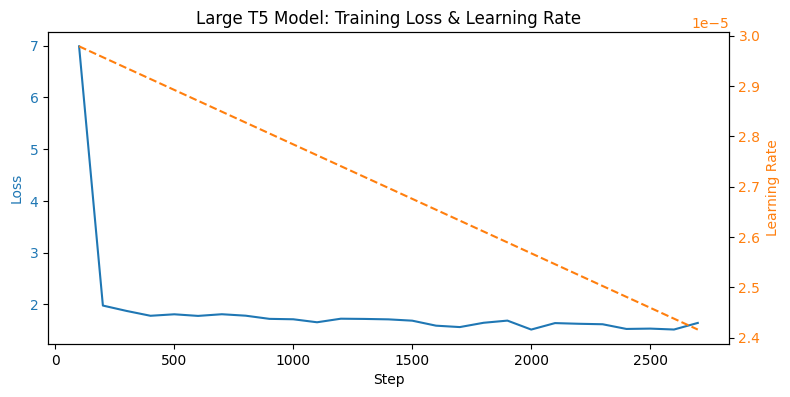

In [11]:
# Plot training loss and learning rate for the large T5 model
with open("results/checkpoint-2772/trainer_state.json") as f:
    trainer_state = json.load(f)
log_history = trainer_state["log_history"]
steps = [entry["step"] for entry in log_history if "loss" in entry]
losses = [entry["loss"] for entry in log_history if "loss" in entry]
lrs = [entry["learning_rate"] for entry in log_history if "learning_rate" in entry]

fig, ax1 = plt.subplots(figsize=(8,4))
color = 'tab:blue'
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss', color=color)
ax1.plot(steps, losses, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(steps, lrs, color=color, linestyle='--', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('Large T5 Model: Training Loss & Learning Rate')
plt.show()

In [12]:
# Plot training loss for the tiny T5 model (if available)
import os
tiny_log_path = "tiny_results/trainer_state.json"
if os.path.exists(tiny_log_path):
    with open(tiny_log_path) as f:
        tiny_trainer_state = json.load(f)
    tiny_log_history = tiny_trainer_state["log_history"]
    tiny_steps = [entry["step"] for entry in tiny_log_history if "loss" in entry]
    tiny_losses = [entry["loss"] for entry in tiny_log_history if "loss" in entry]
    plt.figure(figsize=(8,4))
    plt.plot(tiny_steps, tiny_losses, label='Tiny Model Loss', color='tab:green')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Tiny T5 Model: Training Loss')
    plt.legend()
    plt.show()
else:
    print("No tiny model training log found. (Expected at tiny_results/trainer_state.json)")

No tiny model training log found. (Expected at tiny_results/trainer_state.json)


---

**Summary:**
- The tiny, aligned dataset yields perfect translations for in-domain examples.
- Out-of-domain or noisy inputs result in poor, generic, or nonsensical outputs, highlighting the importance of dataset alignment.
- BLEU and ROUGE metrics provide quantitative evaluation, but qualitative inspection is essential.
- Training curves show the difference in convergence between tiny and large models/datasets.